In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spla
from scipy import sparse
import time
from IPython.display import display, clear_output
import finite
import timesteppers

In [2]:
class StateVector:

    def __init__(self, variables):
        var0 = variables[0]
        self.N = len(var0)
        size = self.N*len(variables)
        self.data = np.zeros(size)
        self.variables = variables
        self.gather()

    def gather(self):
        for i, var in enumerate(self.variables):
            np.copyto(self.data[i*self.N:(i+1)*self.N], var)

    def scatter(self):
        for i, var in enumerate(self.variables):
            np.copyto(var, self.data[i*self.N:(i+1)*self.N])

In [3]:
class ViscousBurgers:
    
    def __init__(self, u, nu, d, d2):
        self.X = StateVector([u])

        N = len(u)
        self.M = sparse.eye(N, N)
        self.L = -nu*d2.matrix

        f = lambda X: -X.data*(d @ X.data)

        self.F = f

In [4]:
class IMEXTimestepper(timesteppers.Timestepper):

    def __init__(self, eq_set):
        super().__init__()
        self.X = eq_set.X
        self.M = eq_set.M
        self.L = eq_set.L
        self.F = eq_set.F

    def step(self, dt):
        self.X.data = self._step(dt)
        self.X.scatter()
        self.dt = dt
        self.t += dt
        self.iter += 1

## Crank-Nicolson--Adams-Bashforth
This timestepping scheme is
$$(M + 0.5\Delta t L)u^{n+1} = M u^{n} - 0.5 \Delta t L u^{n} + 1.5 \Delta t F(u^{n}) - 0.5\Delta t F(u^{n-1}).$$
This can only be used starting on the second step, because it requires $u^{n-1}$ for the Adams-Bashforth part. So for the first step, we'll use Euler; after that we'll use CNAB.

In [5]:
class CNAB(IMEXTimestepper):

    def _step(self, dt):
        if self.iter == 0:
            LHS = self.M + dt*self.L
            LU = spla.splu(LHS.tocsc(), permc_spec='NATURAL')
            
            self.FX = self.F(self.X)
            RHS = self.M @ self.X.data + dt*self.FX
            self.FX_old = self.FX
            return LU.solve(RHS)
        else:
            if dt != self.dt or self.iter == 1:
                LHS = self.M + 0.5*dt*self.L
                self.LU = spla.splu(LHS.tocsc(), permc_spec='NATURAL')
            
            self.FX = self.F(self.X)
            RHS = self.M @ self.X.data - 0.5*dt*self.L @ self.X.data + 3/2*dt*self.FX - 1/2*dt*self.FX_old
            self.FX_old = self.FX
            return self.LU.solve(RHS)

In [6]:
grid = finite.UniformPeriodicGrid(200, 5)
x = grid.values

IC = 0*x
for i, xx in enumerate(x):
    if xx > 1 and xx <= 2:
        IC[i] = (xx-1)
    elif xx > 2 and xx < 3:
        IC[i] = (3-xx)

x_s = 1+np.sqrt(2+2*3)

sol = 0*x
for i, xx in enumerate(x):
    if xx > 1 and xx <= x_s:
        sol[i] = 2/(x_s-1)**2*(xx-1)

d = finite.DifferenceUniformGrid(1, 4, grid)
d2 = finite.DifferenceUniformGrid(2, 4, grid)
nu = 0.5e-2

u = np.copy(IC)
vburgers_problem = ViscousBurgers(u, nu, d, d2)

<ufunc 'solve1'>
<ufunc 'solve1'>


/opt/miniconda3/envs/446-1/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


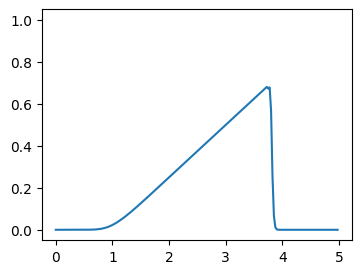

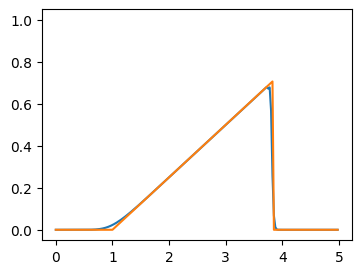

In [7]:
ts = CNAB(vburgers_problem)
alpha = 0.4
dt = alpha*grid.dx
output_cadence = 2

fig = plt.figure(figsize=(4,3))
p, = plt.plot(x, u)
while ts.t < 3:
    ts.step(dt)
    if ts.iter % output_cadence == 0:
        p.set_ydata(u)
        clear_output(wait=True)
        display(fig)
plt.plot(x, sol)

## Wave Equation

We want to solve
$$\partial_t^2 u = \partial_x^2 u,$$
which can be rewritten as
$$\partial_t u - v = 0$$
$$\partial_t v - \partial_x^2 u = 0$$

In [8]:
class Wave:
    
    def __init__(self, u, v, d2):
        self.X = StateVector([u, v])
        N = len(u)
        I = sparse.eye(N, N)
        Z = sparse.csr_matrix((N, N))
        
        M00 = I
        M01 = Z
        M10 = Z
        M11 = I
        self.M = sparse.bmat([[M00, M01],
                              [M10, M11]])
        
        L00 = Z
        L01 = -I
        L10 = -d2.matrix
        L11 = Z
        self.L = sparse.bmat([[L00, L01],
                              [L10, L11]])
        
        self.F = lambda X: 0*X.data

When initializing the simulation we must specify both $u$ and $v$.

In [9]:
grid = finite.UniformPeriodicGrid(100, 2*np.pi)
x = grid.values

In [10]:
u = np.exp(-(x-np.pi)**2*8)
v = 0*u

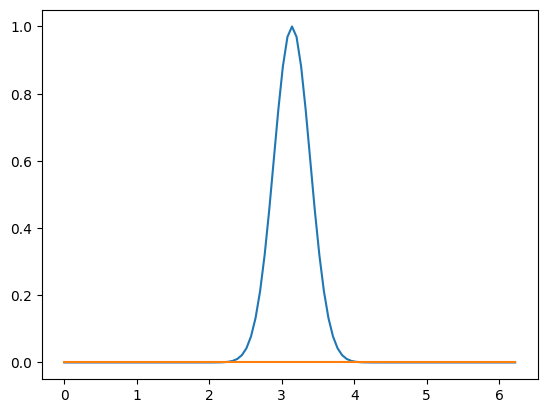

In [11]:
plt.figure()
plt.plot(x, u)
plt.plot(x, v)

In [12]:
d2 = finite.DifferenceUniformGrid(2, 2, grid)
wave_problem = Wave(u, v, d2)

<ufunc 'solve1'>


In [13]:
wave_problem.L @ wave_problem.X.data

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

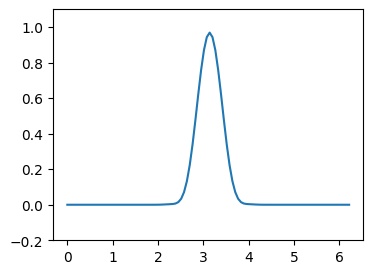

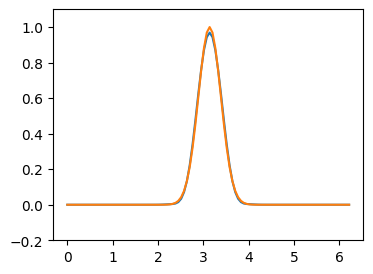

In [15]:
u[:] = np.exp(-(x-np.pi)**2*8)
v[:] = 0
wave_problem.X.gather()
ts = CNAB(wave_problem)
alpha = 0.2
dt = alpha*grid.dx

output_cadence = 5

fig = plt.figure(figsize=(4,3))
p, = plt.plot(x, u)
plt.ylim([-0.2,1.1])
while ts.t < 2*np.pi:
    ts.step(dt)
    if ts.iter % output_cadence == 0:
        p.set_ydata(u)
        clear_output(wait=True)
        display(fig)
plt.plot(x, np.exp(-(x-np.pi)**2*8))